# Equatorial Thermal and Zonal Velocity Structure

This notebook contains code to plot various equatorial properties from ACCESS-OM2 simulations and compare to observations. All plots are currently focused on the Equatorial Pacific but can easily be adapted to the Atlantic or Indian, or to off-equatorial locations. 

Several sets of plots are included:

1) Longitude-depth and latitude-depth slices of temperature and zonal velocity compared to the Johnson et al. observations.

2) Longitude-depth temperature bias plots compared to WOA13.

3) Vertical profiles of temperature and zonal velocity at a specified horizontal location (140W, 0N below) compared to TAO, Johnson and WOA13 data.

4) Longitude-time Hovmoeller plots describing the seasonal cycle of SST (compared to WOA13) and zonal velocity (compared to drifter observations).

Results are compared to several observational products:

1) The WOA2013 climatological data set located in `/g/data/hh5/tmp/cosima/woa13`.

2) The Johnson et al. (2002, doi: 10.1016/s0079-6611(02)00021-6) observational data set located in `/g/data/ik11/observations/Johnson2002`.

3) TAO array mooring data located in `/g/data/ik11/observations/TAO`.

4) Laurindo et al. 2017 drifter data set for surface velocities located in `/g/data/hh5/tmp/cosima/observations/original/drifter_monthlymeans.nc`.

1, 2 and 4 are spatially resolved data sets, while the TAO moorings are only used for the vertical profile plotting.

### Load packages, session, workers and define experiments

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore") 

import cosima_cookbook as cc

from dask.distributed import Client

In [2]:
# Load workers:
client = Client(n_workers=14)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34309/status,
Dashboard: /proxy/34309/status,Workers: 14
Total threads: 14,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46275,Workers: 14
Dashboard: /proxy/34309/status,Total threads: 14
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:45425,Total threads: 1
Dashboard: /proxy/45967/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:40555,


## Plot vertical profiles at the Equator compared to TAO, Johnson and WOA13 data

Here we plot vertical profiles of temperature and zonal velocity from the models and compare to the TAO, Johnson and WOA13 data sets.

The TAO data can be downloaded from https://www.pmel.noaa.gov/tao/drupal/disdel/ and for the locations listed below is sitting in `/g/data/ik11/observations/TAO` directory.

We start out by defining functions to extract profiles from a given longitude from WOA13, TAO and the Johnson data. 


In [30]:
# TAO data extraction function:
obs_th = 2500 # This criteria denotes the minimum number of observations at a given depth required to include this point in the comparison.
def get_TAO(lonTAO):
    # Load temperature:
    tao_file_temp = xr.open_dataset('/g/data/ik11/observations/TAO/t0n' + lonTAO + '_dy.cdf')
    tao_temp = tao_file_temp['T_20'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))
    tao_temp = tao_temp.where(tao_temp!=1.e35)
    count = np.count_nonzero(~np.isnan(tao_temp), axis=0)
    tao_temp = tao_temp.isel(depth=count>=obs_th) # Only average if more than x observations at given depth
    
    # Load zonal velocity from ADCP data:
    tao_file_u = xr.open_dataset('/g/data/ik11/observations/TAO/adcp0n' + lonTAO + '_dy.cdf')
    tao_u = tao_file_u['u_1205'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))/100.
    tao_u = tao_u.where(abs(tao_u)<=100.)
    count = np.count_nonzero(~np.isnan(tao_u), axis=0)
    tao_u = tao_u.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth

    # Load zonal velocity from current data:
    tao_file_uc = xr.open_dataset('/g/data/ik11/observations/TAO/cur0n' + lonTAO + '_dy.cdf')
    tao_uc = tao_file_uc['U_320'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))/100.
    tao_uc = tao_uc.where(abs(tao_uc)<=100.)
    count = np.count_nonzero(~np.isnan(tao_uc), axis=0)
    tao_uc = tao_uc.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth
    
    return tao_temp, tao_u, tao_uc

# Johnson data function:
def get_Joh(lonJoh):
    joh_file = xr.open_dataset('/g/data/ik11/observations/Johnson2002/meanfit_m.cdf')
    joh_temp = joh_file['POTEMPM']
    joh_u = joh_file['UM']

    joh_temp_eq = joh_temp.sel(ZDEP1_50=slice(0,400)).sel(YLAT11_101=0., method='nearest').sel(XLON=lonJoh,method='nearest')
    joh_u_eq = joh_u.sel(ZDEP1_50=slice(0,400)).sel(YLAT11_101=0., method='nearest').sel(XLON=lonJoh,method='nearest')
    dep_joh = joh_temp_eq.ZDEP1_50
    
    return joh_temp_eq, joh_u_eq, dep_joh
    
# WOA data function:
def get_WOA(lonWOA):
    temp_WOA13_10 = cc.querying.getvar('025_KDS50', 'temp',session).mean('time').sel(GRID_Y_T=0.,method='nearest')
    woa_temp_eq = temp_WOA13_10.sel(GRID_X_T=lonWOA,method='nearest')
    
    return woa_temp_eq

Next we define a function to extract data from the models at a given longitude

In [31]:
def find_Eqpt(ekey,lon):
    
    file = paths[ekey] + 'output030/ocean/ocean.nc'
    data = xr.open_dataset(file)
    # Extract temperature
    temp = data.temp
    temp_eq = temp.sel(st_ocean=slice(depths[0],depths[1])).sel(yt_ocean=0., method='nearest')\
                        .sel(xt_ocean=lon, method='nearest').mean('time').load() - 273.15
    temp_eq.attrs['units'] = 'degrees Celsius'
    
    # Extract velocity
    u = data.u
    u_eq = u.sel(st_ocean=slice(depths[0],depths[1])).sel(yu_ocean=0., method='nearest')\
                        .sel(xu_ocean=lon, method='nearest').mean('time').load()*100
    u_eq.attrs['units'] = 'cms-1'
    
    return temp_eq, u_eq

Next we define the different longitudes that we wish to plot (since each dataset uses a different type of longitude):

In [32]:
# Define longitudes
lons = {'140w': {'mod': -140.,'tao': '140w','joh': 220.,'woa': -140.},
        '165e': {'mod': -195.,'tao': '165e','joh': 165.,'woa': -195.},
        '110w': {'mod': -110.,'tao': '110w','joh': 250.,'woa': -110.}
        }
depths = (0,300)    # Define depth range for all plots [m]

Finally, lets plot some profiles

In [33]:
# Define runs:
base = '/g/data/e14/rmh561/access-om2/archive/'
paths = {'GFDL50':base + '1deg_jra55_ryf_gfdl50/',
         'KDS50':base + '1deg_jra55_ryf_kds50/',
         'KDS75':base + '1deg_jra55_ryf_kds75/',
         'KDS100':base + '1deg_jra55_ryf_kds100/',
         'KDS135':base + '1deg_jra55_ryf_kds135/'}

In [34]:
temp,u = find_Eqpt('GFDL50',-140.)

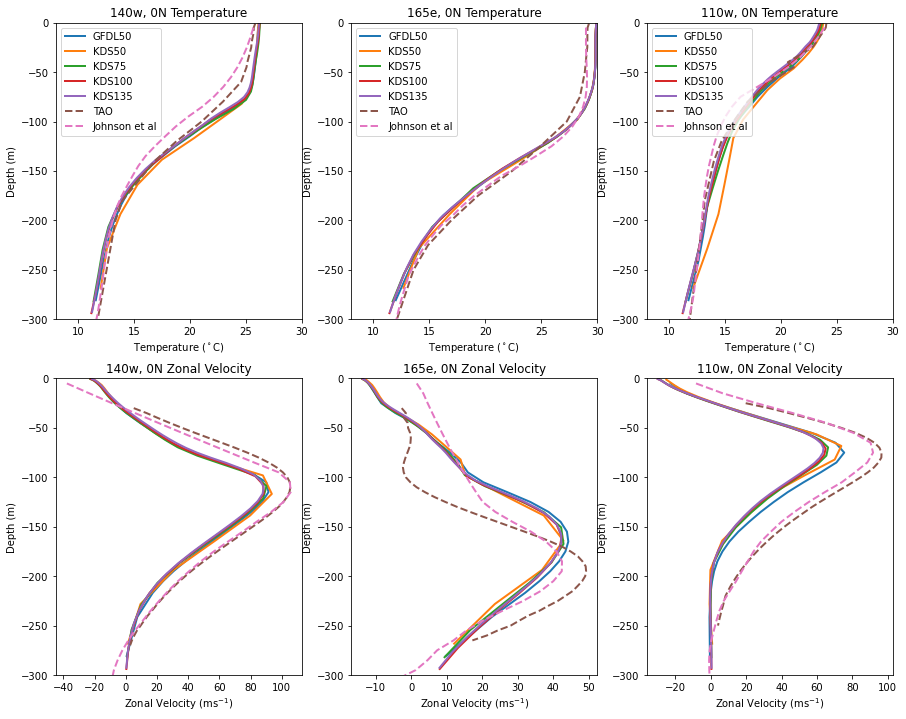

In [35]:
f = plt.figure(figsize=(15,12),facecolor='white')

ekeys = ['GFDL50','KDS50','KDS75','KDS100','KDS135']
nln = len(lons)
tax = []
uax = []
for j, lkey in enumerate(lons.keys()):
         
    tax.append(plt.subplot(2,nln,j+1))
    uax.append(plt.subplot(2,nln,j+nln+1))

    # Loop through and plot models:
    for i, ekey in enumerate(ekeys):
        t_eq, u_eq = find_Eqpt(ekey,lons[lkey]['mod'])
        tax[j].plot(t_eq.values,-t_eq.st_ocean.values,label=ekey,linewidth=2)
        uax[j].plot(u_eq.values,-u_eq.st_ocean.values,linewidth=2)

    # Extract observational data
    tao_temp, tao_u, tao_uc = get_TAO(lons[lkey]['tao'])
    joh_temp_eq, joh_u_eq, dep_joh = get_Joh(lons[lkey]['joh'])
#    woa_temp_eq = get_WOA(lons[lkey]['woa'])
    
    # Ploty observational temperatures
    tax[j].plot(tao_temp.mean('time'),-tao_temp.depth,'--',linewidth=2,label='TAO')
    tax[j].plot(joh_temp_eq,-dep_joh,'--',linewidth=2,label='Johnson et al')
#    tax[j].plot(woa_temp_eq.values,-woa_temp_eq.ZT.values,'--',linewidth=2,label='WOA13')
    tax[j].set_xlabel('Temperature ($^\circ$C)')
    tax[j].set_ylabel('Depth (m)')
    tax[j].legend(loc=2)
    tax[j].set_ylim([-300.,0.])
    tax[j].set_xlim([8.,30.])
    tax[j].set_title(lons[lkey]['tao'] + ', 0N Temperature')
 
    # Plot observational zonal velocities (note, there is no U data from WOA13)
    uax[j].plot(tao_u.mean('time')*100.,-tao_u.depth,'--',linewidth=2) # ADCP data
    # uax[j].plot(tao_uc.mean('time')*100.,-tao_uc.depth,':',linewidth=2) # Current meter data
    uax[j].plot(joh_u_eq*100.,-dep_joh,'--',linewidth=2)
    uax[j].set_xlabel('Zonal Velocity (ms$^{-1}$)')
    uax[j].set_ylabel('Depth (m)')
    uax[j].set_ylim([-300.,0.])
    uax[j].set_title(lons[lkey]['tao'] + ', 0N Zonal Velocity')
    
#savefigure('Equatorial_Pacific_profiles_110W_140W_165E_01degKv')

## Seasonal cycle of SST and zonal velocity along the Equator

Finally, we show an example of plotting a Hovemoeller plot of the seasonal cycle of temperature and zonal velocity against observations. This uses the `groupby` function to calculate a climatology for each variable.

First, define a function to extract the model data and take a climatology and the climatological anomaly

In [19]:
depth = 0. # Define depth [m]
lats = (-5.,5.) # Define latitude range to average over [degrees]
lons = (-217,-95) # Define longitude range to plot [degrees]

def find_hov(ekey):

    expt = exptdict[ekey]['expt']
    n_files = exptdict[ekey]['n_files']
    itime = exptdict[ekey]['itime']
    ftime = exptdict[ekey]['ftime']
    
    # Extract temperature
    temp = cc.querying.getvar(expt, 'temp',session,
                          chunks={'st_ocean': None}, n=n_files,ncfile='ocean_month.nc',
                             start_time=itime,end_time=ftime)
    temp_tot = temp.sel(st_ocean=depth,method='nearest').sel(yt_ocean=slice(lats[0],lats[1])).mean('yt_ocean')\
                        .sel(xt_ocean=slice(lons[0],lons[1])).load() - 273.15
    temp_tot.attrs['units'] = 'degrees Celsius'
    
    # Take climatology:
    temp_tot = temp_tot.groupby('time.month').mean('time')
    
    temp_anom = np.ma.anom(temp_tot,axis=0)
    
    # Extract velocity
    u = cc.querying.getvar(expt, 'u',session,
                          chunks={'st_ocean': None}, n=n_files,ncfile='ocean_month.nc',
                           start_time=itime,end_time=ftime)
    u_tot = u.sel(st_ocean=depth,method='nearest').sel(yu_ocean=slice(lats[0],lats[1])).mean('yu_ocean')\
                        .sel(xu_ocean=slice(lons[0],lons[1])).load()*100.
    u_tot.attrs['units'] = 'cms-1'
        
    # Take climatology:
    u_tot = u_tot.groupby('time.month').mean('time')
    
    u_anom = np.ma.anom(u_tot,axis=0)
    
    return temp_tot, temp_anom, u_tot, u_anom

Next, get the observations, first WOA13 temperature:

In [20]:
temp_WOA13 = cc.querying.getvar('025_KDS50', 'temp',session).sel(GRID_Y_T=slice(lats[0],lats[1])).mean('GRID_Y_T').sel(ZT=depth,method='nearest').sel(GRID_X_T=slice(lons[0],lons[1]))
temp_WOA13_anom = np.ma.anom(temp_WOA13,axis=0)

Next, zonal surface velocity from drifters. The drifter data set is taken from:

Laurindo, L., A. Mariano, and R. Lumpkin, 2017: An improved near-surface velocity climatology for the global ocean from drifter observations Deep-Sea Res. I, 124, pp.73-92, doi:10.1016/j.dsr.2017.04.009 .

And is currently in `/g/data/hh5/tmp/cosima/observations/original/drifter_monthlymeans.nc`

In [21]:
obs_file = xr.open_dataset('/g/data/hh5/tmp/cosima/observations/original/drifter_monthlymeans.nc').rename({'Lat':'latitude','Lon':'longitude'})
obs_u = obs_file['U']
# latitude: 5S-5N, longitude: 45E-100E
obs_u_eq = obs_u.sel(latitude=slice(lats[0],lats[1])).sel(longitude=slice(lons[0],lons[1]))
m_obs_u_eq = obs_u_eq.mean('latitude')
a_obs_u_eq = np.ma.anom(m_obs_u_eq,axis=1)
new_a_obs_u_eq = np.transpose(a_obs_u_eq)

Finally, we plot the SST hovmoller and the zonal velocity hovmoeller

Text(0.5, 0.98, 'SST seasonal cycle in Equatorial Pacific (degC)')

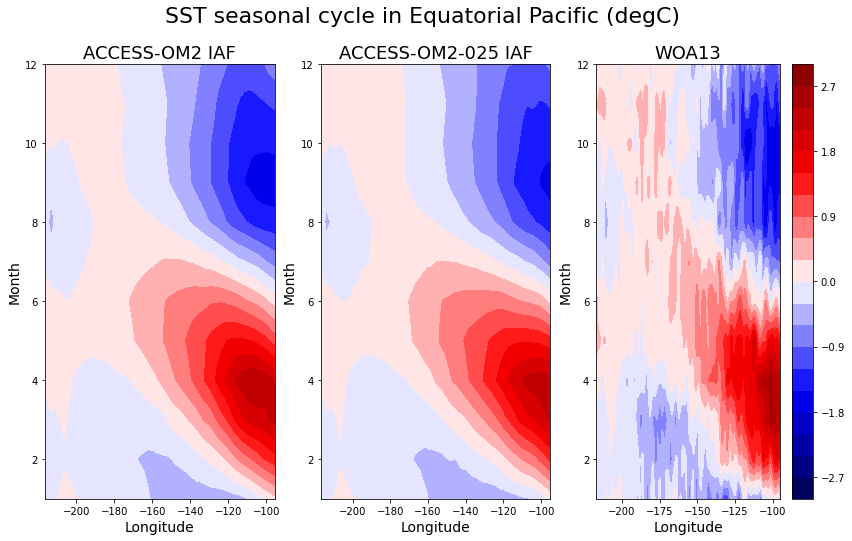

In [22]:
# Plot SST hovmoeller against WOA13
Tmax = 3; Tmin = -Tmax; delT = 0.3
clevels = np.arange(Tmin,Tmax+delT,delT)

fig = plt.figure(figsize=(14,8))

ekeys = ['1degIAF','025degIAF']

for i, ekey in enumerate(ekeys):
    temp_tot, temp_anom, u_tot, u_anom = find_hov(ekey)

    ax = plt.subplot(1,3,i+1)
    cax = plt.contourf(temp_tot.xt_ocean,temp_tot.month,temp_anom,levels=clevels,cmap=plt.cm.seismic )
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Month', fontsize=14 )
    ax.set_title(exptdict[ekey]['model'], fontsize=18)

ax = plt.subplot(1,3,3)
cax = ax.contourf(temp_WOA13.GRID_X_T,np.arange(12)+1,temp_WOA13_anom,levels=clevels,cmap=plt.cm.seismic )
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Month', fontsize=14 )
ax.set_title('WOA13', fontsize=18)
cbar = plt.colorbar(cax)

fig.suptitle('SST seasonal cycle in Equatorial Pacific (degC)', fontsize=22)

Text(0.5, 0.98, 'Zonal velocity seasonal cycle in Equatorial Pacific (cms-1)')

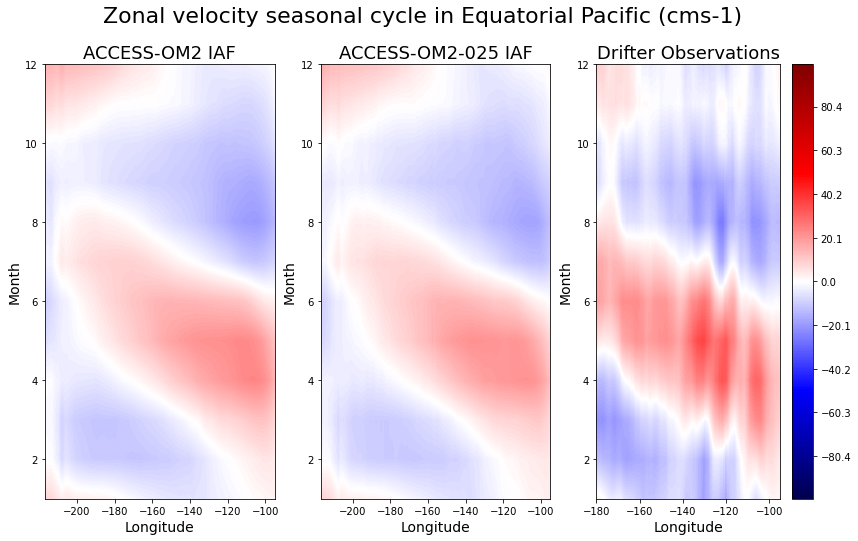

In [23]:
# Plot Zonal velocity hovmoeller:
Tmax = 100.; Tmin = -Tmax; delT = 0.1
clevels = np.arange(Tmin,Tmax+delT,delT)

fig = plt.figure(figsize=(14,8))

ekeys = ['1degIAF','025degIAF']

for i, ekey in enumerate(ekeys):
    temp_tot, temp_anom, u_tot, u_anom = find_hov(ekey)

    ax = plt.subplot(1,3,i+1)
    cax = plt.contourf(u_tot.xu_ocean,u_tot.month,u_anom,levels=clevels,cmap=plt.cm.seismic )
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Month', fontsize=14 )
    ax.set_title(exptdict[ekey]['model'], fontsize=18)

ax = plt.subplot(1,3,3)
cax = ax.contourf(obs_u_eq.longitude, np.arange(12)+1, new_a_obs_u_eq*100., levels=clevels, cmap=plt.cm.seismic )
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Month', fontsize=14 )
cbar = plt.colorbar(cax)
ax.set_title('Drifter Observations', fontsize=18)

fig.suptitle('Zonal velocity seasonal cycle in Equatorial Pacific (cms-1)', fontsize=22)